In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,confusion_matrix

In [3]:
df = pd.read_csv(r"D:\vs code\Projects\MachineLearning\Spamclassifier\spam.csv",encoding="ansi")

## Data Cleaning

### Removing Unamed Columns

In [4]:
df.head()
df = df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [19]:
df['v1'].value_counts()

v1
0    4825
1     747
Name: count, dtype: int64

### Removing Dulpicates

In [23]:
df.duplicated().sum()
df.drop_duplicates(keep='first',inplace = True)

### Label Encoding

v1
0    4479
1     628
Name: count, dtype: int64


([<matplotlib.patches.Wedge at 0x1b49944c050>,
 [Text(0.5141402209434452, -0.972450427121211, 'ham'),
  Text(-0.51414007410751, 0.9724505047542134, 'spam')],
 [Text(0.28044012051460643, -0.5304275057024787, '87.7%'),
  Text(-0.28044004042227816, 0.5304275480477527, '12.3%')])

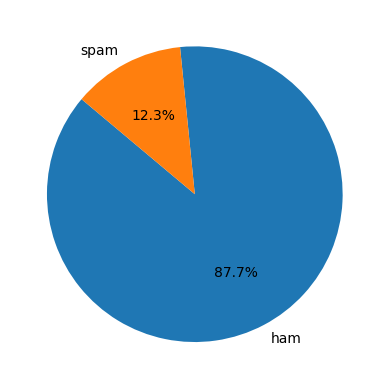

In [32]:
le = LabelEncoder()
df['v1'] = le.fit_transform(df['v1'])
print(df['v1'].value_counts())
plt.pie(df['v1'].value_counts(), labels=['ham', 'spam'], autopct='%1.1f%%', startangle=140)

## TEXT PREPROCESSING

### Lowercasing

In [6]:
columns_to_lowercase = ['v1', 'v2']
for col in columns_to_lowercase:
    if col in df.columns:
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].astype(str).str.lower()
            print(f"Column '{col}' has been lowercased.")
df.head()

Column 'v1' has been lowercased.
Column 'v2' has been lowercased.


,v1,v2
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


### Url removal

In [7]:

import re
url_pattern = re.compile(r'https?://\S+|www\.\S+|\S+\.(com|org|net|gov|edu|uk|ca|in|io|co|biz|info|xyz|me|app|dev|blog|shop|online|site|store|tech|club|live|solutions|ai|io|cloud)\b')
def remove_urls(text):
    text = str(text) # Ensure text is string
    return url_pattern.sub(r'', text)
df['v2_nourl'] = df['v2'].apply(remove_urls)
df['v2_nourl'][15]

'xxxmobilemovieclub: to use your credit, click the wap link in the next txt message or click here>>  ?n=qjkgighjjgcbl'

### Punctuation removal

In [8]:
def clean_text(text):
    return str(text).translate(str.maketrans('', '', string.punctuation)).strip()

df['v2_clean'] = df['v2_nourl'].apply(clean_text)
df['v2_clean'].head()

0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in 2 a wkly comp to win fa cup fina...
3          u dun say so early hor u c already then say
4    nah i dont think he goes to usf he lives aroun...
Name: v2_clean, dtype: object

### Chat Word Removal

In [9]:
chat_words_map = {
    'lol': 'laughing out loud',
    'brb': 'be right back',
    'g2g': 'got to go',
    'btw': 'by the way',
    'omg': 'oh my god',
    'wtf': 'what the fuck',
    'u': 'you',
    'r': 'are',
    'ur': 'your',
    'lyk': 'like',
    '2': 'to',
    '4': 'for',
    'cya': 'see you',
    'msg': 'message',
    'pls': 'please',
    'plz': 'please',
    'thx': 'thanks',
    'ty': 'thank you',
    'coz': 'because',
    'b4': 'before',
    'idk': 'i do not know',
    'imo': 'in my opinion',
    'irl': 'in real life',
    'fyi': 'for your information',
    'np': 'no problem',
    'ttyl': 'talk to you later',
    'wbu': 'what about you',
    'c' : 'can',
    'n':'and',
    'k':'ok',
    'dun' : 'dont'
}
def expand_word(text):
    words = text.split()
    expanded_words = []
    for word in words:
        if word in chat_words_map.keys():
            expanded_words.append(chat_words_map[word])
        else:
            expanded_words.append(word)
    return ' '.join(expanded_words)

df['v2_expChat'] = df['v2_clean'].apply(expand_word)
df['v2_expChat'].head()

0    go until jurong point crazy available only in ...
1                            ok lar joking wif you oni
2    free entry in to a wkly comp to win fa cup fin...
3    you dont say so early hor you can already then...
4    nah i dont think he goes to usf he lives aroun...
Name: v2_expChat, dtype: object

### Removal Of Stop Word

In [10]:
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)
df['v2_nostop'] = df['v2_expChat'].apply(remove_stopwords)
df['v2_nostop'].head()

0    go jurong point crazy available bugis great wo...
1                                ok lar joking wif oni
2    free entry wkly comp win fa cup final tkts 21s...
3                       dont say early hor already say
4          nah dont think goes usf lives around though
Name: v2_nostop, dtype: object

### Steming and Tokenization

In [11]:
'''nltk.download('punkt')
nltk.download('')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
stemmer = PorterStemmer()
def apply_stemming(text):
    if pd.isna(text):
        return text
    text = str(text)
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)
df['v2_stemmed'] = df['v2_nostop'].apply(apply_stemming)
df['v2_stemmed'].head()
import nltk
import os

print("NLTK Data Paths:")
for path in nltk.data.path:
    print(path)

found_punkt = False
for path in nltk.data.path:
    punkt_dir = os.path.join(path, 'tokenizers', 'punkt')
    if os.path.exists(punkt_dir) and os.path.isdir(punkt_dir):
        if os.path.exists(os.path.join(punkt_dir, 'english.pickle')):
            print(f"\n'punkt' tokenizer found at: {punkt_dir}")
            found_punkt = True
            break
if not found_punkt:
    print("\n'punkt' tokenizer not found or incomplete in any NLTK data paths.")
import nltk
import os

custom_nltk_data_path = os.path.join(os.getcwd(), 'nltk_data')
os.makedirs(custom_nltk_data_path, exist_ok=True) 

nltk.data.path.append(custom_nltk_data_path)

print(f"Attempting to download 'punkt' to: {custom_nltk_data_path}")
nltk.download('punkt', download_dir=custom_nltk_data_path, force=True)

print("\nDownload attempt complete. Verify 'punkt' is in the specified folder.")

print("\nNLTK data paths after adding custom path:")
for path in nltk.data.path:
    print(path)'''

'nltk.download(\'punkt\')\nnltk.download(\'\')\nfrom nltk.stem import PorterStemmer\nfrom nltk.tokenize import word_tokenize\nstemmer = PorterStemmer()\ndef apply_stemming(text):\n    if pd.isna(text):\n        return text\n    text = str(text)\n    tokens = word_tokenize(text)\n    stemmed_tokens = [stemmer.stem(word) for word in tokens]\n    return \' \'.join(stemmed_tokens)\ndf[\'v2_stemmed\'] = df[\'v2_nostop\'].apply(apply_stemming)\ndf[\'v2_stemmed\'].head()\nimport nltk\nimport os\n\nprint("NLTK Data Paths:")\nfor path in nltk.data.path:\n    print(path)\n\nfound_punkt = False\nfor path in nltk.data.path:\n    punkt_dir = os.path.join(path, \'tokenizers\', \'punkt\')\n    if os.path.exists(punkt_dir) and os.path.isdir(punkt_dir):\n        if os.path.exists(os.path.join(punkt_dir, \'english.pickle\')):\n            print(f"\n\'punkt\' tokenizer found at: {punkt_dir}")\n            found_punkt = True\n            break\nif not found_punkt:\n    print("\n\'punkt\' tokenizer not fou

In [12]:
df.drop(columns =['v2', 'v2_nourl', 'v2_clean', 'v2_expChat'], inplace=True)
df.rename(columns={'v2_nostop': 'v2'}, inplace=True)
df.head()

,v1,v2
0,ham,go jurong point crazy available bugis great wo...
1,ham,ok lar joking wif oni
2,spam,free entry wkly comp win fa cup final tkts 21s...
3,ham,dont say early hor already say
4,ham,nah dont think goes usf lives around though


## Text Representation

### Tfidf

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['v2'])
print(tfidf_vectorizer.vocabulary_)

{'go': 3746, 'jurong': 4615, 'point': 6329, 'crazy': 2472, 'available': 1399, 'bugis': 1858, 'great': 3843, 'world': 9041, 'la': 4772, 'buffet': 1856, 'cine': 2190, 'got': 3803, 'amore': 1166, 'wat': 8809, 'ok': 5899, 'lar': 4811, 'joking': 4583, 'wif': 8939, 'oni': 5930, 'free': 3542, 'entry': 3127, 'wkly': 8993, 'comp': 2305, 'win': 8952, 'fa': 3264, 'cup': 2527, 'final': 3388, 'tkts': 8258, '21st': 452, 'may': 5253, '2005': 439, 'text': 8099, '87121': 863, 'receive': 6725, 'questionstd': 6617, 'txt': 8463, 'ratetcs': 6669, 'apply': 1252, '08452810075over18s': 71, 'dont': 2890, 'say': 7080, 'early': 2999, 'hor': 4170, 'already': 1140, 'nah': 5593, 'think': 8172, 'goes': 3760, 'usf': 8606, 'lives': 4973, 'around': 1303, 'though': 8191, 'freemsg': 3550, 'hey': 4066, 'darling': 2589, 'weeks': 8862, 'word': 9027, 'back': 1448, 'id': 4276, 'like': 4923, 'fun': 3612, 'still': 7743, 'tb': 8030, 'xxx': 9116, 'std': 7718, 'chgs': 2135, 'send': 7174, '150': 352, 'rcv': 6681, 'even': 3175, 'bro

## Text Classification

In [ ]:
X_tfidf = tfidf_vectorizer.fit_transform(df['v2'])
y = df['v1']

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
	X_tfidf, y, test_size=0.2, random_state=42
)

### SVM

In [16]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm * 100:.2f}%_")
precision_svm = precision_score(y_test, y_pred_svm, pos_label=1)
print(f"Precision (Spam): {precision_svm:.4f}")
recall_svm = recall_score(y_test, y_pred_svm, pos_label=1)
print(f"Recall (Spam): {recall_svm:.4f}")
f1_svm = f1_score(y_test, y_pred_svm, pos_label=1)
print(f"F1-Score (Spam): {f1_svm:.4f}")
print("--- Confusion Matrix ---")
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print(conf_matrix_svm)

SVM Accuracy: 97.67%_
Precision (Spam): 0.9844
Recall (Spam): 0.8400
F1-Score (Spam): 0.9065
--- Confusion Matrix ---
[[963   2]
 [ 24 126]]


### Naive bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test,y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb * 100:.2f}%")
precision_nb = precision_score(y_test, y_pred_nb, pos_label=1)
print(f"Precision (Spam): {precision_nb:.4f}")
recall_nb = recall_score(y_test, y_pred_nb, pos_label=1)
print(f"Recall (Spam): {recall_nb:.4f}")
f1_nb = f1_score(y_test, y_pred_nb, pos_label=1)
print(f"F1-Score (Spam): {f1_nb:.4f}")
print("--- Confusion Matrix ---")
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
print(conf_matrix_nb)

Naive Bayes Accuracy: 96.68%
Precision (Spam): 1.0000
Recall (Spam): 0.7533
F1-Score (Spam): 0.8593
--- Confusion Matrix ---
[[965   0]
 [ 37 113]]


### Logistic regression

In [18]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression()
LR_model.fit(X_train_tfidf,y_train)
y_pred_LR = LR_model.predict(X_test_tfidf)
accuracy_LR = accuracy_score(y_test,y_pred_LR)
print(f"Logistic Regression Accuracy: {accuracy_LR * 100:.2f}%")
precision_LR = precision_score(y_test, y_pred_LR, pos_label=1)
print(f"Precision (Spam): {precision_LR:.4f}")
recall_LR = recall_score(y_test, y_pred_LR, pos_label=1)
print(f"Recall (Spam): {recall_LR:.4f}")
f1_LR = f1_score(y_test, y_pred_LR, pos_label=1)
print(f"F1-Score (Spam): {f1_LR:.4f}")
print("--- Confusion Matrix ---")
conf_matrix_LR = confusion_matrix(y_test, y_pred_LR)
print(conf_matrix_LR)

Logistic Regression Accuracy: 94.17%
Precision (Spam): 0.9570
Recall (Spam): 0.5933
F1-Score (Spam): 0.7325
--- Confusion Matrix ---
[[961   4]
 [ 61  89]]
